In [1]:
import spacy
import string
import pickle as pkl
import pandas as pd
from collections import Counter
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# import data 
data_dir = './data/'

# Read in dataset (pre-tokenized)
train_df = pd.read_csv(data_dir+"snli_train.tsv",sep='\t')
val_df = pd.read_csv(data_dir+"snli_val.tsv",sep='\t')

# Process the label to usable format: (neutral:0, entailment:1, contradiction:2)
mapping = {'neutral': 0, 'entailment': 1, 'contradiction': 2}
train_df = train_df.applymap(lambda s: mapping.get(s) if s in mapping else s)
val_df = val_df.applymap(lambda s: mapping.get(s) if s in mapping else s)

# Then, load preprocessed train, val and test datasets
train_data_tokens_1 = pkl.load(open(data_dir+"train_data_tokens_1.p", "rb"))
train_data_tokens_2 = pkl.load(open(data_dir+"train_data_tokens_2.p", "rb"))
all_train_tokens = pkl.load(open(data_dir+"all_train_concat_tokens.p", "rb"))
val_data_tokens_1 = pkl.load(open(data_dir+"val_data_tokens_1.p", "rb"))
val_data_tokens_2 = pkl.load(open(data_dir+"val_data_tokens_2.p", "rb"))

# getting the target values for training and validation
train_target = train_df['label'].tolist()
val_target = val_df['label'].tolist()

# double checking
print ("Train dataset size (sentence 1) is {}".format(len(train_data_tokens_1)))
print ("Train dataset size (sentence 2) is {}".format(len(train_data_tokens_2)))
print ("Val dataset size (sentence 1) is {}".format(len(val_data_tokens_1)))
print ("Val dataset size (sentence 2) is {}".format(len(val_data_tokens_2)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))
print ("Total number of *unique* tokens in train dataset is {}".format(len(set(all_train_tokens))))

Train dataset size (sentence 1) is 100000
Train dataset size (sentence 2) is 100000
Val dataset size (sentence 1) is 1000
Val dataset size (sentence 2) is 1000
Total number of tokens in train dataset is 2038281
Total number of *unique* tokens in train dataset is 19643


In [3]:
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size=10000):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

# convert token to id in the dataset
def token2index_dataset(token2id, tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data


def bow_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list_1 = []
    data_list_2 = []
    label_list = []
    length_list_1 = []
    length_list_2 = []
    
    for datum in batch:
        label_list.append(datum[4])
        length_list_1.append(datum[2])
        length_list_2.append(datum[3])
    # padding
    for datum in batch:
        # padding for sentence 1
        padded_vec_1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        # padding for sentence 2
        padded_vec_2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        data_list_1.append(padded_vec_1)
        data_list_2.append(padded_vec_2)
    return [torch.from_numpy(np.array(data_list_1)), torch.from_numpy(np.array(data_list_2)), torch.LongTensor(length_list_1), torch.LongTensor(length_list_2), torch.LongTensor(label_list)]


# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct = 0
    total = 0
    model.eval()
    for data1, data2, length1, length2, labels in loader:
        data_batch_1, data_batch_2, length_batch_1, length_batch_2, label_batch = data1, data2, length1, length2, labels
        outputs = F.softmax(model(data_batch_1, data_batch_2, length_batch_1, length_batch_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, label_batch)
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return 1.0 * correct / total, loss


In [4]:
# Define Classes

class BuildDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """ 
    def __init__(self, data_list_1, data_list_2, target_list):
        """
        @param data_list_1: list of sentence 1 tokens 
        @param data_list_2: list of sentence 2 tokens 
        @param target_list: list of newsgroup targets 
        """
        self.data_list_1 = data_list_1
        self.data_list_2 = data_list_2
        self.target_list = target_list
        assert (len(self.data_list_1) == len(self.target_list))

    def __len__(self):
        return len(self.data_list_1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_idx_1 = self.data_list_1[key][:MAX_SENTENCE_LENGTH]
        token_idx_2 = self.data_list_2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx_1, token_idx_2, len(token_idx_1), len(token_idx_2), label]
    

class My_NN(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim, interact, drop):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(My_NN, self).__init__()
        # pay attention to padding_idx
        l1_dim = 100
        l2_dim = 80
        self.interact = interact
        if interact == 'concat':
            self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
            self.hidden1 = nn.Linear(emb_dim*2, l1_dim)
        elif interact == 'product':
            self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
            self.hidden1 = nn.Linear(emb_dim, l1_dim)
        self.dropout = nn.Dropout(p=drop)
        self.hidden2 = nn.Linear(l1_dim, l2_dim)
        self.linear = nn.Linear(l2_dim, 3)
        
    def forward(self, data1, data2, length_1, length_2):
        """
        
        @param data1: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review in sentence1 that is represented using n-gram index. Note that they are padded to have same length.
        @param data2: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review in sentence2 that is represented using n-gram index. Note that they are padded to have same length.
        @param length1: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data1.
        @param length2: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data2.
        """
        out_1 = self.dropout(self.embed(data1))
        out_1 = torch.sum(out_1, dim=1)
        out_1 /= length_1.view(length_1.size()[0],1).expand_as(out_1).float()

        out_2 = self.dropout(self.embed(data2))
        out_2 = torch.sum(out_2, dim=1)
        out_2 /= length_2.view(length_2.size()[0],1).expand_as(out_2).float()
        
        if self.interact == 'concat':
            out = torch.cat((out_1, out_2), dim=1) 
        elif self.interact == 'product':
            out = torch.mul(out_1, out_2)
        
        out = F.relu(self.hidden1(out.float()))
        out = F.relu(self.hidden2(out.float()))
        # return logits
        out = self.linear(out.float())
        return out

In [5]:
# adding loss 


def nn_pipeline(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate, drop, cnt, interact='concat'):
    
    train_acc_list = []
    val_acc_list = [] 
    
    train_loss_list = []
    val_loss_list = [] 
    
    print('Running nn with vocab_size {}, MAX_SENTENCE_LENGTH {}, BATCH_SIZE {}, emb_dim {}, learning_rate {}, dropout_rate {}, interact way {}'.format(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate, drop, interact))

    token2id, id2token = build_vocab(all_train_tokens, vocab_size)
    train_data_indices_1 = token2index_dataset(token2id, train_data_tokens_1)
    train_data_indices_2 = token2index_dataset(token2id, train_data_tokens_2)
    val_data_indices_1 = token2index_dataset(token2id, val_data_tokens_1)
    val_data_indices_2 = token2index_dataset(token2id, val_data_tokens_2)
    
    train_dataset = BuildDataset(train_data_indices_1, train_data_indices_2, train_target)
    val_dataset = BuildDataset(val_data_indices_1, val_data_indices_2, val_target)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=bow_collate_func,
                                           shuffle=True)

    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=bow_collate_func,
                                               shuffle=True)
    
    model = My_NN(len(id2token), emb_dim, interact, drop)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    num_epochs = 10 # number epoch to train
    for epoch in range(num_epochs):
        for i, (data1, data2, length1, length2, labels) in enumerate(train_loader):
            model.train()
            data_batch_1, data_batch_2, length_batch_1, length_batch_2, label_batch = data1, data2, length1, length2, labels
            optimizer.zero_grad()
            outputs = model(data_batch_1, data_batch_2, length_batch_1, length_batch_2)
            loss = criterion(outputs, label_batch)
            #print("Loss in the epoch loops {}".format(loss))
            loss.backward()
            optimizer.step()
            # validate every 1000 iterations
            if i > 0 and i % 1000 == 0:
                train_acc, train_loss = test_model(train_loader, model)
                val_acc, val_loss = test_model(val_loader, model)
                
                train_acc_list.append(train_acc)
                val_acc_list.append(val_acc)
                
                train_loss_list.append(train_loss)
                val_loss_list.append(val_loss)
                
    train_acc, train_loss = test_model(train_loader, model)
    val_acc, val_loss = test_model(val_loader, model)

    print("After training for {} epochs, Train Acc {}, Val Acc {}, Train Loss {}, Val Loss {}".format(num_epochs, train_acc, val_acc, train_loss, val_loss))
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    filename = 'nn_model_'+str(cnt)+'.sav'
    pkl.dump(model, open(filename, 'wb'))
    print("model {} saved".format(cnt))
    
    return train_acc_list, val_acc_list, train_loss_list, val_loss_list


In [6]:
def make_plot(train_acc_list, val_acc_list, train_loss_list, val_loss_list):
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plot_len = len(train_acc_list)

    ax1=plt.subplot(121)
    ax1.plot(range(plot_len), train_acc_list, label = 'train accuracy', alpha = 0.5)
    ax1.plot(range(plot_len), val_acc_list, label = 'val accuracy', alpha = 0.5)
    ax1.plot(range(plot_len), [0.6]*plot_len, label = '60% Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax2=plt.subplot(122)
    ax2.plot(range(len(train_loss_list)), train_loss_list, label = 'train loss', alpha = 0.5)
    ax2.plot(range(len(val_loss_list)), val_loss_list, label = 'val loss', alpha = 0.5)
    ax2.plot(range(len(val_loss_list)), [1]*len(val_loss_list), label = '1.0 loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Cross Entropy Loss')
    ax2.legend()
    plt.show()
    plt.clf()

Running nn with vocab_size 8000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.01, dropout_rate 0.08, interact way concat
After training for 10 epochs, Train Acc 0.87619, Val Acc 0.639, Train Loss 0.7330251336097717, Val Loss 0.8250104188919067
model 1 saved


/home/qjy-lexi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


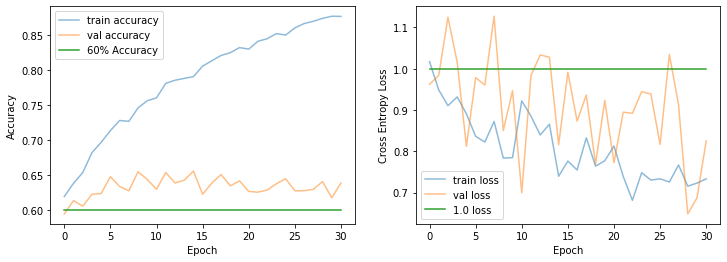

Running nn with vocab_size 10000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.01, dropout_rate 0.08, interact way concat
After training for 10 epochs, Train Acc 0.8913, Val Acc 0.658, Train Loss 0.6854336857795715, Val Loss 0.870651125907898
model 2 saved


<Figure size 432x288 with 0 Axes>

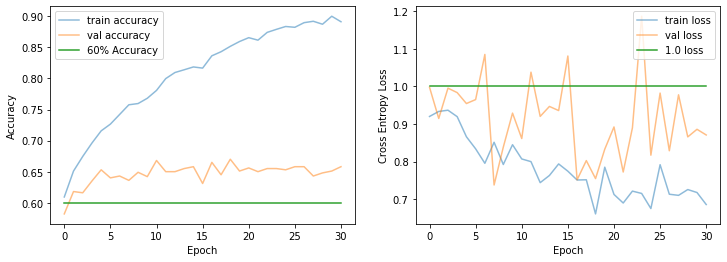

Running nn with vocab_size 12000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.01, dropout_rate 0.08, interact way concat
After training for 10 epochs, Train Acc 0.89537, Val Acc 0.651, Train Loss 0.6778726577758789, Val Loss 0.906635046005249
model 3 saved


<Figure size 432x288 with 0 Axes>

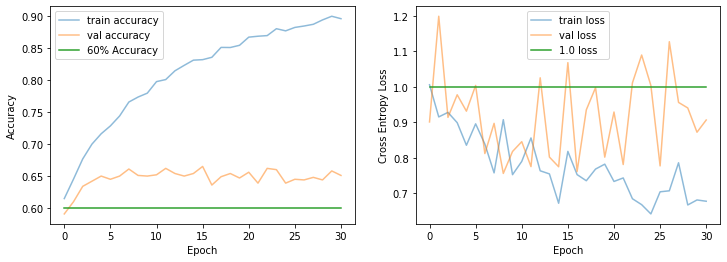

Running nn with vocab_size 10000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 60, learning_rate 0.01, dropout_rate 0.08, interact way concat
After training for 10 epochs, Train Acc 0.89351, Val Acc 0.654, Train Loss 0.7128967046737671, Val Loss 0.8642119765281677
model 4 saved


<Figure size 432x288 with 0 Axes>

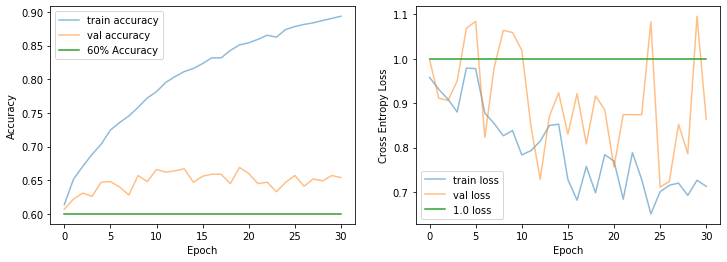

Running nn with vocab_size 10000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.01, dropout_rate 0.08, interact way concat
After training for 10 epochs, Train Acc 0.89141, Val Acc 0.644, Train Loss 0.7778985500335693, Val Loss 0.8442834615707397
model 5 saved


<Figure size 432x288 with 0 Axes>

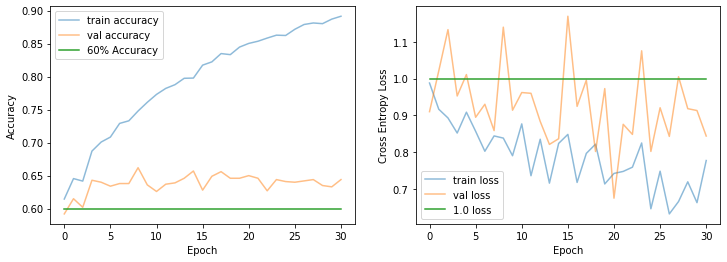

Running nn with vocab_size 10000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 100, learning_rate 0.01, dropout_rate 0.08, interact way concat
After training for 10 epochs, Train Acc 0.90023, Val Acc 0.655, Train Loss 0.667048454284668, Val Loss 0.8454530835151672
model 6 saved


<Figure size 432x288 with 0 Axes>

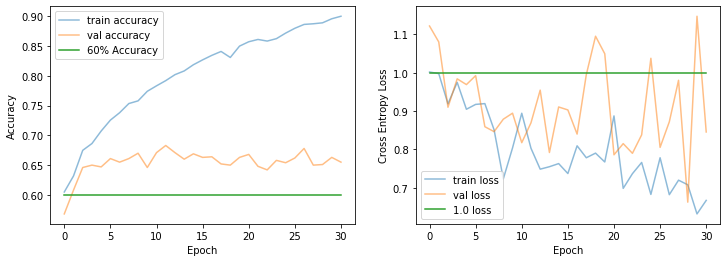

Running nn with vocab_size 10000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.01, dropout_rate 0.08, interact way concat
After training for 10 epochs, Train Acc 0.88969, Val Acc 0.669, Train Loss 0.6899158954620361, Val Loss 0.9109037518501282
model 7 saved


<Figure size 432x288 with 0 Axes>

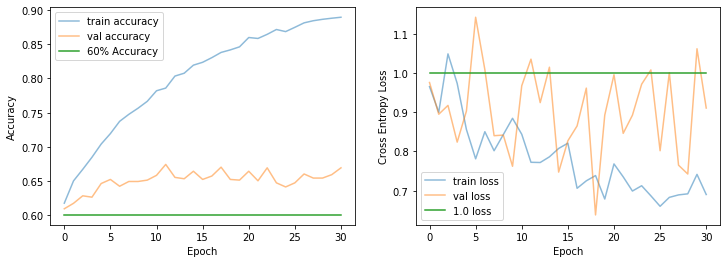

Running nn with vocab_size 10000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.01, dropout_rate 0.08, interact way product
After training for 10 epochs, Train Acc 0.95922, Val Acc 0.63, Train Loss 0.5819849967956543, Val Loss 1.1425164937973022
model 8 saved


<Figure size 432x288 with 0 Axes>

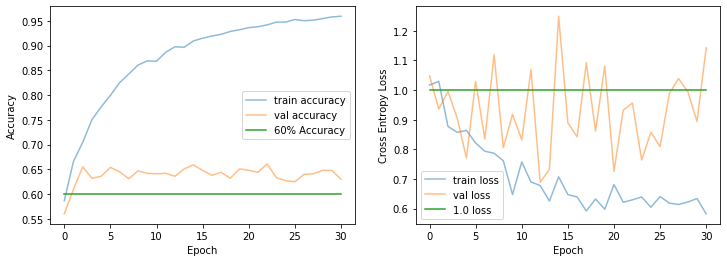

<Figure size 432x288 with 0 Axes>

In [7]:
learning_rate = 0.01
MAX_SENTENCE_LENGTH = 100
BATCH_SIZE = 32
num_epochs = 10 # number epoch to train
cnt = 1

# group 1: interaction = 'cat', emb_dim = 80, max_vocab_size = [8000, 10000, 12000]
vocab_list = [8000, 10000, 12000]
embed_dim_list = [80]
interact_list=['concat']
drop_list = [0.08]

for vocab_size in vocab_list:
    for emb_dim in embed_dim_list:
        for interact in interact_list:
            for drop in drop_list:
                train_acc_list, val_acc_list, train_loss_list, val_loss_list = nn_pipeline(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate, drop, cnt, interact)
                cnt += 1
                make_plot(train_acc_list, val_acc_list, train_loss_list, val_loss_list)

# group 2: interaction = 'cat', max_vocab_size = 10000, emb_dim = [60,80,100]
vocab_list = [10000]
embed_dim_list = [60, 80, 100]
interact_list = ['concat']
drop_list = [0.08]

for vocab_size in vocab_list:
    for emb_dim in embed_dim_list:
        for interact in interact_list:
            for drop in drop_list:
                train_acc_list, val_acc_list, train_loss_list, val_loss_list = nn_pipeline(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate, drop, cnt, interact)
                cnt += 1
                make_plot(train_acc_list, val_acc_list, train_loss_list, val_loss_list)

# group 3: max_vocab_size = 10000, emb_dim = 80, interaction  = ['cat', 'mul']
vocab_list = [10000]
embed_dim_list = [80]
interact_list = ['concat', 'product']
drop_list = [0.08]

for vocab_size in vocab_list:
    for emb_dim in embed_dim_list:
        for interact in interact_list:
            for drop in drop_list:
                train_acc_list, val_acc_list, train_loss_list, val_loss_list = nn_pipeline(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate, drop, cnt, interact)
                cnt += 1
                make_plot(train_acc_list, val_acc_list, train_loss_list, val_loss_list)


Running nn with vocab_size 8000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.01, dropout_rate 0.08, interact way product
After training for 10 epochs, Train Acc 0.95755, Val Acc 0.636, Train Loss 0.5863143801689148, Val Loss 0.9685555100440979
model 9 saved


/home/qjy-lexi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


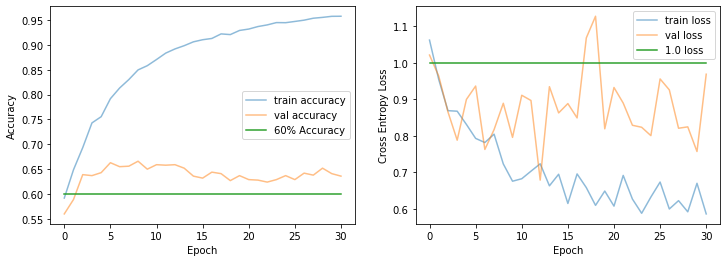

Running nn with vocab_size 10000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.01, dropout_rate 0.08, interact way product
After training for 10 epochs, Train Acc 0.95594, Val Acc 0.63, Train Loss 0.5974904298782349, Val Loss 0.6963623762130737
model 10 saved


<Figure size 432x288 with 0 Axes>

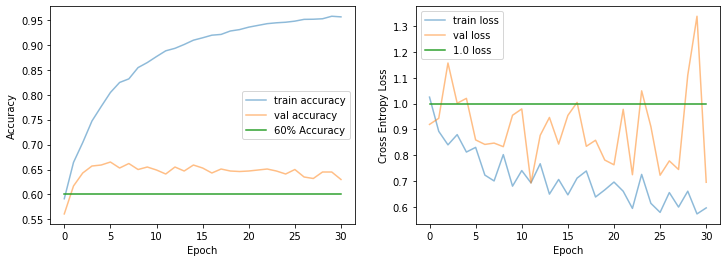

Running nn with vocab_size 12000, MAX_SENTENCE_LENGTH 100, BATCH_SIZE 32, emb_dim 80, learning_rate 0.01, dropout_rate 0.08, interact way product
After training for 10 epochs, Train Acc 0.96109, Val Acc 0.648, Train Loss 0.5738105177879333, Val Loss 0.9103919863700867
model 11 saved


<Figure size 432x288 with 0 Axes>

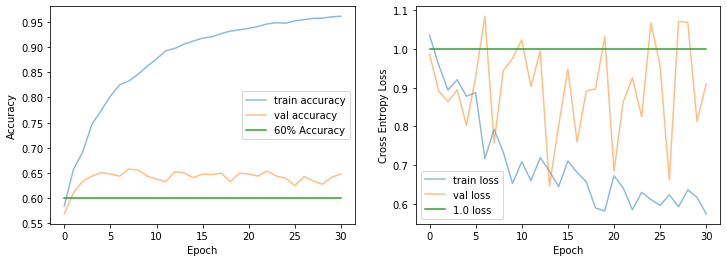

<Figure size 432x288 with 0 Axes>

In [8]:
# group 4: interaction = 'product', emb_dim = 80, max_vocab_size = [8000, 10000, 12000]
vocab_list = [8000, 10000, 12000]
embed_dim_list = [80]
interact_list=['product']
drop_list = [0.08]

for vocab_size in vocab_list:
    for emb_dim in embed_dim_list:
        for interact in interact_list:
            for drop in drop_list:
                train_acc_list, val_acc_list, train_loss_list, val_loss_list = nn_pipeline(vocab_size, MAX_SENTENCE_LENGTH, BATCH_SIZE, emb_dim, learning_rate, drop, cnt, interact)
                cnt += 1
                make_plot(train_acc_list, val_acc_list, train_loss_list, val_loss_list)
